## Download and Install Required Libraries

Github: [source codes](https://github.com/qubvel/segmentation_models.pytorch/blob/master/README.md)

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9e06a305547eed8a462350b3cf4eed611b8707245093dfe132ae706bcad16c0d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=ff11396cab460aaff312f9f275b795a073c2cf4b5c6ab6461c01dc6ec2c00ef8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
!nvidia-smi

Mon Oct  9 20:13:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set Global Seed

In [ ]:
#import random
#random.seed(13204942)

## Mount Google Drive to access your data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Ultrasound_project/'

### Data Preparation

In [ ]:
import cv2
import os
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
data_path = root_path + 'train_data_split/'

In [ ]:
# process original mask to binary mask
def preprocess_mask(mask):
  # we need to use sigmoid
  mask[mask == 255.0] = 1.0

  mask = np.stack([mask], axis=-1).astype('float')
  return mask

In [ ]:
# Dataset class
class HeadDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_Annotation.png"))
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype('float32')
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      aug = self.transform(image=image, mask=mask)
      image = aug["image"]
      mask = aug["mask"]

    return image, mask

In [ ]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Build Model

We are using an existing Pytorch library, Segmentation Models (SMP), with Neural Networks for Image
Segmentation. The official library document is [here](https://smp.readthedocs.io/).

P. Iakubovskii, “Segmentation models pytorch,” 2019.

*@misc{Iakubovskii:2019,
  Author = {Pavel Iakubovskii},
  Title = {Segmentation Models Pytorch},
  Year = {2019},
  Publisher = {GitHub},
  Journal = {GitHub repository},
  Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
}*

**Avaliable architectures:**
 - Unet [[paper](https://arxiv.org/abs/1505.04597)] [[docs](https://smp.readthedocs.io/en/latest/models.html#unet)]


**Available Encoders:**
The following is a list of supported encoders in the SMP library. The selected encoder and its pre-trained weights (encoder_name and encoder_weights parameters) are shown as below.

* ResNet

| Encoder   | Weights               | Params, M |
| --------- | --------------------- | --------- |
| resnet18  | imagenet / ssl / swsl | 11M       |
| resnet50  | imagenet / ssl / swsl | 23M       |
| resnet101 | imagenet              | 42M       |
| resnet152 | imagenet              | 58M       |

* Densenet

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|densenet121                     |imagenet                        |6M                              |
|densenet169                     |imagenet                        |12M                             |
|densenet201                     |imagenet                        |18M                             |
|densenet161                     |imagenet                        |26M                             |

* Inception

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|inceptionresnetv2               |imagenet /  imagenet+background |54M                             |
|inceptionv4                     |imagenet /  imagenet+background |41M                             |
|xception                        |imagenet                        |22M                             |

* Mobilenet

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|mobilenet_v2                    |imagenet                        |2M                              |

* VGG

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|vgg11                           |imagenet                        |9M                              |
|vgg13                           |imagenet                        |9M                              |
|vgg16                           |imagenet                        |14M                             |
|vgg19                           |imagenet                        |20M                             |

In [ ]:
import os
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

Set pre-trained encoders. **Choose one ENCODER from above encoders list to build your model !**

In [ ]:
# if encoder needs to be frozen, set below flag = True
freeze_flag = False

In [ ]:
ENCODER = 'mobilenet_v2'

ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['head'] # a binary classification problem to classify each pixel into one of the two classes, Class 1: Head or Class 2: Not Head
#ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation

AUX_PARAMS=dict(
    pooling='max',           # one of 'avg', 'max'
    activation='sigmoid',    # activation function, default is None
    classes=1,               # define number of output labels
)

**Select one of below architectures to build your model !**

Build a deep learning architecture using library segmentation_models_pytorch, and then load pre-trained CNN to encoders inside the architecture.

#### U-Net

<img src=https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png width="450">

In [ ]:
# create segmentation model with pretrained encoder
unet_model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,  # pre-training on ImageNet
    decoder_attention_type=None,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=None
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 24.6MB/s]


In [ ]:
model = unet_model

if freeze_flag:
  model_name = f'unet_frozen_{ENCODER}'
else:
  model_name = f'unet_{ENCODER}'

In [ ]:
model.classification_head = None

In [ ]:
#print(model)

#### Freeze Decoder layers partially

In [ ]:
# freeze segmentation head
for param in model.segmentation_head.parameters():
  param.requires_grad = False

In [ ]:
if freeze_flag:
  for param in model.encoder.parameters():
    param.requires_grad = False
else:
  for param in model.encoder.parameters():
    param.requires_grad = True

In [ ]:
freeze_decoder = True

In [ ]:
if freeze_decoder:
  # freeze all layers except the bottleneck
  '''
  for param in model.encoder.model.blocks[0].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[1].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[2].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[3].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[4].parameters():
    param.requires_grad = False
  '''

  for param in model.decoder.blocks[0].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[1].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[2].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[3].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[4].parameters():
    param.requires_grad = False


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

In [ ]:
from torchsummary import summary

print(summary(model, (3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

## Training Model

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 10
NUM_EPOCHS = 20 # 5 warm-up
NUM_WORKERS = 2
# UNet DeepLab3+
#IMAGE_HEIGHT = 240  # 540 originally
#IMAGE_WIDTH = 240  # 800 originally
# FPN
IMAGE_HEIGHT = 512  # 540 originally
IMAGE_WIDTH = 512  # 800 originally

PIN_MEMORY = True
LOAD_MODEL = False

In [ ]:
DEVICE

'cuda'

#### Set-up Data Loader

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

#### Load Dataset

In [ ]:
print(data_path)
#train_ds = torch.load(data_path + 'split_train_size_10.pt')
#train_ds = torch.load(data_path + 'split_train_size_30.pt')
#train_ds = torch.load(data_path + 'split_train_size_50.pt')

test_ds = torch.load(data_path + 'test_data_size_200.pt')

/content/drive/MyDrive/Ultrasound_project/train_data_split/


In [ ]:
print(f'The lenght of train dataset: {len(train_ds)}')
print(f'The lenght of test dataset: {len(test_ds)}')

The lenght of train dataset: 399
The lenght of test dataset: 200


#### Start DataLoader

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

print(len(train_loader))

In [ ]:
val_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

print(len(val_loader))

#### Create a Function for Training

In [ ]:
from tqdm import tqdm
import torch.optim as optim

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)
  losses = []

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      #loss = loss_fn(predictions[0], targets)
      loss = loss_fn(predictions, targets)
      losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  return losses #loss.item()

In [ ]:
def check_accuracy(loader, model, loss_fn, pix_acc, dice, iou, device="cuda", is_train=True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    iou_val = 0.0
    losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            prediction = model(x)
            loss = loss_fn(prediction, y.float())
            losses.append(loss.item())

            #preds = preds[0]
            preds = torch.sigmoid(prediction)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
                )
            iou_val += (preds * y).sum() / (
                (preds + y).sum() - (preds * y).sum() + 1e-8
                )

    p_acc = num_correct/num_pixels*100
    print(f"Got {p_acc} with acc {p_acc:.4f}")
    pix_acc.append(p_acc.item())

    d_score = dice_score * 100 / len(loader)
    print(f"Dice score: {d_score:.4f}")
    dice.append(d_score.item())

    iou_score = iou_val * 100 / len(loader)
    print(f"mIoU: {iou_score:.4f}")
    iou.append(iou_score.item())

    print(f"Got validation loss: {np.mean(losses):.6f}")

    if is_train:
      model.train()

    return pix_acc, dice, iou, losses

#### Start Training

In [ ]:
model = model.to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
best_loss = 1.0

pix_acc = []
dice = []
miou = []
ep_loss = []
tr_loss_global = []
val_loss_global = []

for epoch in range(NUM_EPOCHS):
  print(f"{epoch}:")
  current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
  tr_loss_global += current_loss
  print(".\n")
  print(f"Got training loss: {np.mean(current_loss):.6f}")

  # check accuracy
  pix_acc, dice_score, m_iou, ep_loss = check_accuracy(val_loader, model, loss_fn, pix_acc, dice, miou, device=DEVICE)
  val_loss_global += ep_loss

  # print some examples to a folder
  #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

0:


100%|██████████| 40/40 [01:51<00:00,  2.80s/it, loss=0.574]

.

Got training loss: 0.628919


Got 73.1783447265625 with acc 73.1783
Dice score: 61.5071
mIoU: 44.4806
Got validation loss: 0.577611
1:


100%|██████████| 40/40 [00:13<00:00,  3.00it/s, loss=0.519]

.

Got training loss: 0.533927


Got 82.47954559326172 with acc 82.4795
Dice score: 75.5059
mIoU: 60.7698
Got validation loss: 0.480326
2:


100%|██████████| 40/40 [00:13<00:00,  3.04it/s, loss=0.445]

.

Got training loss: 0.471458


Got 86.33845520019531 with acc 86.3385
Dice score: 80.4289
mIoU: 67.3840
Got validation loss: 0.444476
3:


100%|██████████| 40/40 [00:12<00:00,  3.16it/s, loss=0.43]

.

Got training loss: 0.437446


Got 89.1964340209961 with acc 89.1964
Dice score: 83.8850
mIoU: 72.3381
Got validation loss: 0.425106
4:


100%|██████████| 40/40 [00:13<00:00,  2.98it/s, loss=0.403]

.

Got training loss: 0.418698


Got 90.51113891601562 with acc 90.5111
Dice score: 85.8208
mIoU: 75.2625
Got validation loss: 0.407891
5:


100%|██████████| 40/40 [00:13<00:00,  2.98it/s, loss=0.41]

.

Got training loss: 0.403258


Got 91.73511505126953 with acc 91.7351
Dice score: 87.4203
mIoU: 77.7273
Got validation loss: 0.397249
6:


100%|██████████| 40/40 [00:13<00:00,  3.01it/s, loss=0.38]

.

Got training loss: 0.392908


Got 92.37334442138672 with acc 92.3733
Dice score: 88.3955
mIoU: 79.3134
Got validation loss: 0.388406
7:


100%|██████████| 40/40 [00:12<00:00,  3.29it/s, loss=0.363]

.

Got training loss: 0.381119


Got 93.48493957519531 with acc 93.4849
Dice score: 89.9329
mIoU: 81.7738
Got validation loss: 0.375484
8:


100%|██████████| 40/40 [00:13<00:00,  2.97it/s, loss=0.382]

.

Got training loss: 0.372206


Got 93.83536529541016 with acc 93.8354
Dice score: 90.4713
mIoU: 82.6607
Got validation loss: 0.368848
9:


100%|██████████| 40/40 [00:13<00:00,  2.97it/s, loss=0.355]

.

Got training loss: 0.365489


Got 94.5398178100586 with acc 94.5398
Dice score: 91.4492
mIoU: 84.2925
Got validation loss: 0.360503
10:


100%|██████████| 40/40 [00:13<00:00,  2.98it/s, loss=0.36]

.

Got training loss: 0.358394


Got 94.7889175415039 with acc 94.7889
Dice score: 91.8574
mIoU: 85.0010
Got validation loss: 0.352998
11:


100%|██████████| 40/40 [00:12<00:00,  3.20it/s, loss=0.342]

.

Got training loss: 0.351781


Got 95.33594512939453 with acc 95.3359
Dice score: 92.6467
mIoU: 86.3450
Got validation loss: 0.346170
12:


100%|██████████| 40/40 [00:13<00:00,  2.95it/s, loss=0.342]

.

Got training loss: 0.345362


Got 95.6138916015625 with acc 95.6139
Dice score: 93.0545
mIoU: 87.0489
Got validation loss: 0.343610
13:


100%|██████████| 40/40 [00:13<00:00,  2.96it/s, loss=0.341]

.

Got training loss: 0.341786


Got 95.97056579589844 with acc 95.9706
Dice score: 93.5924
mIoU: 87.9882
Got validation loss: 0.337927
14:


100%|██████████| 40/40 [00:13<00:00,  3.01it/s, loss=0.33]

.

Got training loss: 0.333975


Got 96.14095306396484 with acc 96.1410
Dice score: 93.8706
mIoU: 88.4849
Got validation loss: 0.333476
15:


100%|██████████| 40/40 [00:12<00:00,  3.09it/s, loss=0.333]

.

Got training loss: 0.330725


Got 96.55612182617188 with acc 96.5561
Dice score: 94.4749
mIoU: 89.5595
Got validation loss: 0.327364
16:


100%|██████████| 40/40 [00:12<00:00,  3.15it/s, loss=0.331]

.

Got training loss: 0.326455


Got 96.56141662597656 with acc 96.5614
Dice score: 94.5139
mIoU: 89.6275
Got validation loss: 0.324150
17:


100%|██████████| 40/40 [00:13<00:00,  2.98it/s, loss=0.333]

.

Got training loss: 0.321996


Got 96.78456115722656 with acc 96.7846
Dice score: 94.8199
mIoU: 90.1861
Got validation loss: 0.322231
18:


100%|██████████| 40/40 [00:13<00:00,  2.95it/s, loss=0.309]

.

Got training loss: 0.319752


Got 97.01773071289062 with acc 97.0177
Dice score: 95.1986
mIoU: 90.8570
Got validation loss: 0.316880
19:


100%|██████████| 40/40 [00:13<00:00,  2.99it/s, loss=0.304]

.

Got training loss: 0.317326


Got 96.96895599365234 with acc 96.9690
Dice score: 95.1214
mIoU: 90.7261
Got validation loss: 0.317468


Write results to a txt file.

In [ ]:
np.savetxt("tr_loss_global_222m_50per_1.txt", np.array(tr_loss_global))
np.savetxt("val_loss_global_222m_50per_1.txt", np.array(val_loss_global))

Calculate average Pixel Accuracy:

In [ ]:
print(np.round(np.mean(pix_acc[5:]), 4)) # without warm-up
print(np.round(np.std(pix_acc[5:]), 6)) # without warm-up

Calculate average Dice Score:

In [ ]:
print(np.round(np.mean(dice_score[5:]), 6)) # without warm-up
print(np.round(np.std(dice_score[5:]), 6)) # without warm-up

Calculate average IoU:

In [ ]:
print(np.round(np.mean(m_iou[5:]), 6)) # without warm-up
print(np.round(np.std(m_iou[5:]), 6)) # without warm-up

#### Save Model to G-Drive

In [ ]:
save_flag = True

In [ ]:
# set path to save
save_path = data_path + f'models/'
save_path

'/content/drive/MyDrive/Ultrasound_project/train_data_split/models/'

In [ ]:
def save_checkpoint(state, save_path, filename):
    print("=> Saving checkpoint")
    filepath = save_path + filename
    torch.save(state, filepath)

In [ ]:
model_name

'unet_mobilenet_v2'

In [ ]:
if save_flag:
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
  save_checkpoint(checkpoint, save_path, f"{model_name}_19072023_222m_50per_3.pth.tar")
  print(f"{save_path}{model_name}_19072023_222m_50per_3.pth.tar")

=> Saving checkpoint
/content/drive/MyDrive/Ultrasound_project/train_data_split/models/unet_mobilenet_v2_19072023_222m_50per_3.pth.tar


In [ ]:
model = None
unet_model = None
train_loader = None
val_loader = None
loss_fn = None
optimizer = None
scaler = None

In [ ]:
torch.cuda.empty_cache()

## Evaluation on Test Set

In [ ]:
# load saved models
def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

In [ ]:
test_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
root_path

'/content/drive/MyDrive/Ultrasound_project/'

In [ ]:
save_path = root_path + f'Saved_models/mobilenet_v2/'
save_path

'/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/'

In [ ]:
checkpoint_name = save_path + f"unet_frozen_mobilenet_v2_13072023_model_222m_1.pth.tar"

In [ ]:
#my_Unet_baseline_0712.pth.tar
#my_Unet_baseline_0717.pth.tar
#my_Unet_baseline_0717_1.pth.tar
#my_Unet_baseline_0717_2.pth.tar

#unet_frozen_mobilenet_v2_02062023_model_44m_0.pth.tar
#unet_frozen_mobilenet_v2_12072023_model_44m_1.pth.tar
#unet_frozen_mobilenet_v2_12072023_model_44m_3.pth.tar
#unet_frozen_mobilenet_v2_13072023_model_44m_4.pth.tar

#unet_frozen_mobilenet_v2_13072023_model_222m_1.pth.tar
#unet_frozen_mobilenet_v2_13072023_model_222m_2.pth.tar
#unet_frozen_mobilenet_v2_13072023_model_222m_4.pth.tar
#unet_frozen_mobilenet_v2_13072023_model_222m_6.pth.tar

checkpoint_name

'/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/unet_frozen_mobilenet_v2_13072023_model_222m_1.pth.tar'

In [ ]:
LOAD_MODEL = True

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(checkpoint_name), model)

=> Loading checkpoint


In [ ]:
if torch.cuda.is_available():
    model.cuda()

### Fetal Head

#### HC18 Test Dataset

In [ ]:
VAL_IMG_DIR = root_path + "HC18_UNet_orig/val_images/"
VAL_MASK_DIR = root_path + "HC18_UNet_orig/val_masks/"

In [ ]:
val_ds = HeadDataset(
    image_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    transform=val_transforms,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
test_hc18_pix_acc = []
test_hc18_dice_scores = []
test_hc18_miou = []

# check accuracy
#for i in range(5):
#print(f"Test round {i}:")
check_accuracy(val_loader,
                model,
                loss_fn,
                test_hc18_pix_acc, test_hc18_dice_scores, test_hc18_miou,
                device=DEVICE,
                is_train=False)

Got 98.15953063964844 with acc 98.1595
Dice score: 96.9583
mIoU: 94.1054
Got validation loss: 0.047137


([98.15953063964844],
 [96.95833587646484],
 [94.10543060302734],
 [0.047286804765462875,
  0.041551414877176285,
  0.043017588555812836,
  0.05777060613036156,
  0.060201264917850494,
  0.03728415444493294,
  0.047104835510253906,
  0.03766707703471184,
  0.04433807358145714,
  0.05604222044348717,
  0.05897848680615425,
  0.04822370037436485,
  0.04847319796681404,
  0.069807268679142,
  0.041715580970048904,
  0.044195856899023056,
  0.04161393642425537,
  0.0377417616546154,
  0.036596231162548065,
  0.04312647506594658])

In [ ]:
print(f"Pixel Accuracy: {test_hc18_pix_acc}")
print(f"Dice Score: {test_hc18_dice_scores}")
print(f"Mean IoU: {test_hc18_miou}")

Pixel Accuracy: [98.15953063964844]
Dice Score: [96.95833587646484]
Mean IoU: [94.10543060302734]


In [ ]:
unet_model = None
model = None
torch.cuda.empty_cache()

**NOTE: If the above code block shows AttributeError like the below one, please initialize the model and load weights from saved checkpoint again.**

```
/usr/local/lib/python3.9/dist-packages/torchsummary/torchsummary.py in hook(module, input, output)
     17             m_key = "%s-%i" % (class_name, module_idx + 1)
     18             summary[m_key] = OrderedDict()
---> 19             summary[m_key]["input_shape"] = list(input[0].size())
     20             summary[m_key]["input_shape"][0] = batch_size
     21             if isinstance(output, (list, tuple)):

AttributeError: 'list' object has no attribute 'size'
```

#### Spanish / African Test Dataset

In [ ]:
root_path

'/content/drive/MyDrive/Ultrasound_project/'

In [ ]:
# Spanish/spanishcerebellum_test/images/
# Spanish/spanishthalamic_test/images/
# Spanish/spanishventricular_test/images/

# African/Algeria/images/
# African/Malawi/images/
# African/Egypt/images/

TEST_FPZ_IMG_DIR = root_path + "African/Egypt/images/"
TEST_FPZ_MASK_DIR = root_path + "African/Egypt/masks/"

In [ ]:
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
print(TEST_FPZ_IMG_DIR)
print(len(test_fpz_ds))

/content/drive/MyDrive/Ultrasound_project/African/Egypt/images/
25


In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               loss_fn,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 91.92520141601562 with acc 91.9252
Dice score: 88.5219
mIoU: 79.5302
Got validation loss: 0.282363


([91.92520141601562],
 [88.52193450927734],
 [79.53018188476562],
 [0.24770715832710266, 0.29536938667297363, 0.30401158332824707])

## Result visualization

In [ ]:
test_dataloader = test_fpz_loader
#test_dataloader = test_hc18_loader
#test_dataloader = val_loader

# test_fpz_ds, val_ds
test_ds = test_fpz_ds

In [ ]:
print(len(test_dataloader))

3


In [ ]:
rand_idx = [2,5,8,10,12,14,16,18]

In [ ]:
#rand_idx = random.sample(range(30), k=5) # select your indices here as a list
#subset = torch.utils.data.Subset(test_fpz_ds, rand_idx)
subset = torch.utils.data.Subset(test_ds, rand_idx)
testloader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

Dice Score is 95.122


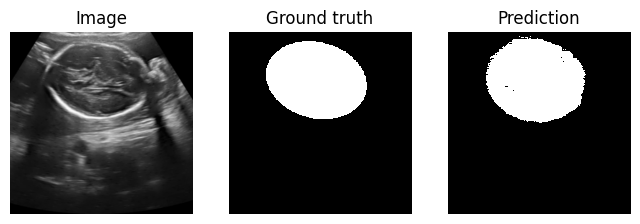

Dice Score is 96.946


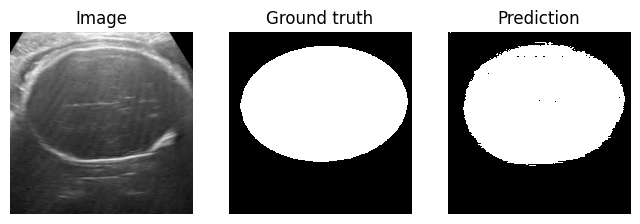

Dice Score is 96.390


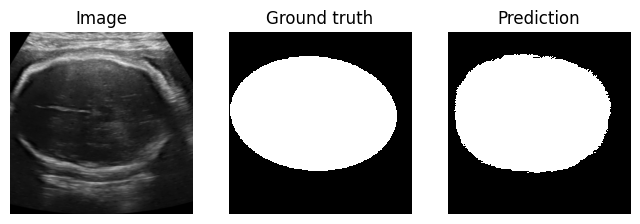

Dice Score is 96.866


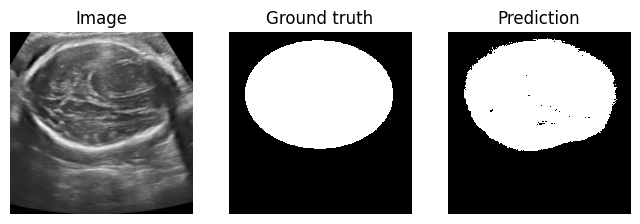

Dice Score is 93.783


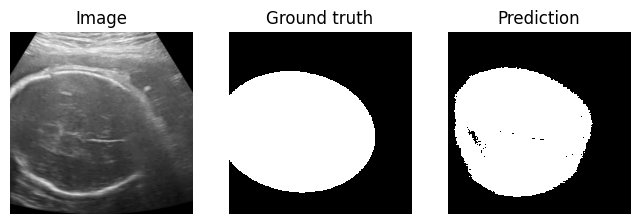

Dice Score is 95.134


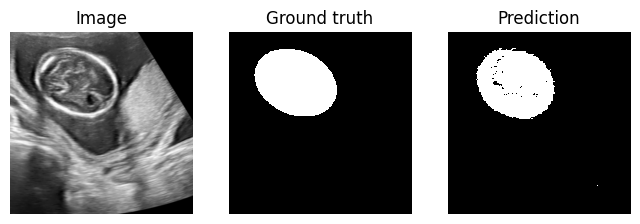

Dice Score is 78.789


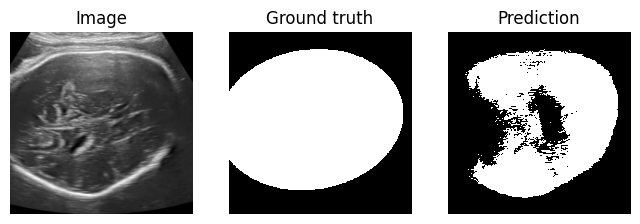

Dice Score is 97.004


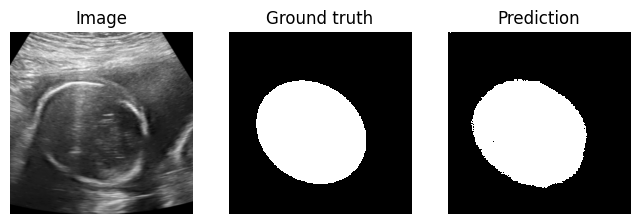

In [ ]:
with torch.no_grad():
  for x, y in testloader_subset:
    image = x.to(DEVICE)
    gt_mask = y.to(DEVICE).unsqueeze(1)
    preds = model(image)
    preds = preds[0]
    preds = (preds > 0.5).float()

    dice_score = (2 * (preds * gt_mask).sum()) / (
        (preds + gt_mask).sum() + 1e-8
        )

    print(f"Dice Score is {dice_score*100:.3f}")

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 3, 1)
    x = x.flatten(0, 1)
    plt.imshow(x.permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(1-y.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(1-preds.cpu().data.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()